In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from kmodes.kmodes import KModes
from warnings import simplefilter
simplefilter(action='ignore',category=UserWarning)
simplefilter(action='ignore',category=FutureWarning)

In [3]:
data=pd.read_csv('D:\datasets.csv',sep=';')

In [4]:
data

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [5]:
class HeartDiseasePrediction:
    def __init__(self,data):
        '''constructor is used to store our main sample training dataset
        1. for our data
        2. for transforming column value into respective class value [Body Mass Index (BMI)]
        3. for transforming column value into respective class value [Mean Arterial Pressure (MAP)]
        4. using column list to store the column name on which outliers have to be detected
        '''
        self.data = data
        self.maledata = None
        self.femaledata = None
        self.cluster_female = None
        self.cluster_male = None
        self.maindata = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.decisiontree = None
        self.random_forest = None
        self.kneighbor = None
        self.kneighbor_tr = []
        self.kneighbor_te = []
        self.rating = []
        self.map_values = []
        self.column = []
    def outlierdetection(self):
        '''Outlier Detection'''
        self.returnColumns()
        self.column=['age' , 'height' , 'weight' , 'ap_hi' , 'ap_lo']
        print('\nOutliers Detecting...')
        for column in self.column:
            if column == 'age':
                print(column,int(self.data[column].min()/365),int(self.data[column].max()/365),sep=' ')
            else:
                print(column,self.data[column].min(),self.data[column].max(),sep='  ')

    def removingoutliers(self):
        '''In this method all outliers of our dataset will be removed
        1. Removing outliers of weight,height,ap_hi,ap_lo that fall below 2.5% and above 97.5% of the given range.
        2. Transforming the column age (measured in days) into years.
        3. Age Bracket using pandas.cut function to categorize each age number into corresponding age bracket
        4. Transforming height and weight column into BMI (Body Mass Index) column into(1 to 6 class)
        5. Using Rating List for arranging values which has to be assigned
        6. Assigning rating values into BMI column of our dataset
        7. Creating Map (Mean Arterial Pressure) mean of ap_hi(Systolic Blood Pressure) and  ap_lo (Diabolic Blood Pressure) Column into MAP

        '''
        self.data.drop(self.data[(self.data['height'] > self.data['height'].quantile(0.975)) | (self.data['height'] < self.data['height'].quantile(0.025))].index,
                inplace=True)
        self.data.drop(self.data[(self.data['weight'] > self.data['weight'].quantile(0.975)) | (self.data['weight'] < self.data['weight'].quantile(0.025))].index,
                inplace=True)
        self.data.drop(self.data[(self.data['ap_hi'] > self.data['ap_hi'].quantile(0.975)) | (self.data['ap_hi'] < self.data['ap_hi'].quantile(0.025))].index,
                inplace=True)
        self.data.drop(self.data[(self.data['ap_lo'] > self.data['ap_lo'].quantile(0.975)) | (self.data['ap_lo'] < self.data['ap_lo'].quantile(0.025))].index,
                inplace=True)

        self.data.drop_duplicates(inplace=True,keep=False)

        self.data['years']=(self.data['age']/365).round().astype(int)
        self.data.drop(['id','age'],axis=1,inplace=True)
        self.data['age_c']=pd.cut(self.data['years'],[0,20,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100],labels=['0-20', '20-30', '30-35', '35-40','40-45',
                                                                    '45-50','50-55','55-60','60-65','65-70','70-75','75-80','80-85','85-90','90-95','95-100'])
        self.data['bmi']=self.data['weight']/((self.data['height']/100)**2)

        for row in self.data['bmi']:
            if row < 18.5: #UnderWeight
                self.rating.append(1)
            elif row > 18.5 and row < 24.9: #Normal Weight
                self.rating.append(2)
            elif row > 24.9 and row < 29.9:
                self.rating.append(3)  # OverWeight
            elif row > 29.9 and row < 34.9:
                self.rating.append(4)  # OverWeight 1
            elif row > 34.9 and row < 39.9:
                self.rating.append(5)   #Overweight 2
            elif row > 39.9 and row < 49.9:
                self.rating.append(6)  #OverWeight 3

        self.data['bmi_c']=self.rating

        self.data['MAP']=((2*self.data['ap_lo'])+self.data['ap_hi'])/3
        for row in self.data['MAP']:
            if row < 69.9:
                self.map_values.append(1) #Low
            elif row > 70 and row  < 79.9:
                self.map_values.append(2)#Normal
            elif row > 79.9 and row < 89.9:  \
                self.map_values.append(3)#Medium
            elif row > 89.9 and row < 99.9:
                self.map_values.append(4)#High
            elif row > 99.9 and row < 109.9:
                self.map_values.append(5)#Above High
            elif row > 109.9 and row < 119.9:
                self.map_values.append(6)#Too High
            elif row > 119.9:
                self.map_values.append(7)#
        self.data['MAP_c']=self.map_values
        self.returnHead()
        print('Outliers successfully removed ')

    def reordercolumn(self):
        print('\nReordering the column of dataset... ')
        self.data=self.data[['gender','height','weight','bmi','ap_hi','ap_lo','MAP','years',
                             'age_c','bmi_c','MAP_c','cholesterol','gluc','smoke','active','cardio']]
        self.returnHead()
        print('Reordered')

    def analyze(self):
        '''In This method we will apply LabelEncoder on our present dataset '''
        self.data=self.data[['gender','age_c','bmi_c','MAP_c','cholesterol','gluc','smoke','active','cardio']]
        le=LabelEncoder()
        self.data=self.data.apply(le.fit_transform)
        self.returnHead()
        print('Analyzed')

    def separatingdata(self):
        '''This method will extract the male and female data from main dataset'''
        self.maledata=self.data.query("gender==0")
        self.femaledata=self.data.query("gender==1")
        self.returnmaleHead()
        print('\n')
        self.returnfemaleHead()

    def graphs(self):
        '''Visualizing the data with the use of graphs for specified columns'''
        column=['age_c','bmi_c','MAP_c','cholesterol','gluc','smoke','active']
        fig,ax=plt.subplots(1,3,figsize=(15,5))
        sns.countplot(x=self.data['age_c'],order=self.data['age_c'].value_counts().index,hue=self.data['cardio'],ax=ax[0])
        sns.countplot(x=self.maledata['age_c'],order=self.maledata['age_c'].value_counts().index,hue=self.maledata['cardio'],ax=ax[1])
        sns.countplot(x=self.femaledata['age_c'],order=self.femaledata['age_c'].value_counts().index,hue=self.femaledata['cardio'],ax=ax[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig1, ax1 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['bmi_c'], order=self.data['bmi_c'].value_counts().index, hue=self.data['cardio'], ax=ax1[0])
        sns.countplot(x=self.maledata['bmi_c'], order=self.maledata['bmi_c'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax1[1])
        sns.countplot(x=self.femaledata['bmi_c'], order=self.femaledata['bmi_c'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax1[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig2, ax2 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['MAP_c'], order=self.data['MAP_c'].value_counts().index, hue=self.data['cardio'], ax=ax2[0])
        sns.countplot(x=self.maledata['MAP_c'], order=self.maledata['MAP_c'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax2[1])
        sns.countplot(x=self.femaledata['MAP_c'], order=self.femaledata['MAP_c'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax2[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig3, ax3 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['cholesterol'], order=self.data['cholesterol'].value_counts().index, hue=self.data['cardio'], ax=ax3[0])
        sns.countplot(x=self.maledata['cholesterol'], order=self.maledata['cholesterol'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax3[1])
        sns.countplot(x=self.femaledata['cholesterol'], order=self.femaledata['cholesterol'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax3[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig4, ax4 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['gluc'], order=self.data['gluc'].value_counts().index, hue=self.data['cardio'], ax=ax4[0])
        sns.countplot(x=self.maledata['gluc'], order=self.maledata['gluc'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax4[1])
        sns.countplot(x=self.femaledata['gluc'], order=self.femaledata['gluc'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax4[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig5, ax5 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['smoke'], order=self.data['smoke'].value_counts().index, hue=self.data['cardio'], ax=ax5[0])
        sns.countplot(x=self.maledata['smoke'], order=self.maledata['smoke'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax5[1])
        sns.countplot(x=self.femaledata['smoke'], order=self.femaledata['smoke'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax5[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()
        fig6, ax6 = plt.subplots(1, 3, figsize=(15, 5))
        sns.countplot(x=self.data['active'], order=self.data['active'].value_counts().index, hue=self.data['cardio'], ax=ax6[0])
        sns.countplot(x=self.maledata['active'], order=self.maledata['active'].value_counts().index, hue=self.maledata['cardio'],
                      ax=ax6[1])
        sns.countplot(x=self.femaledata['active'], order=self.femaledata['active'].value_counts().index,
                      hue=self.femaledata['cardio'], ax=ax6[2])
        ax[0].set_title('All Data')
        ax[1].set_title('Male Data')
        ax[2].set_title('Female Data')
        plt.show()

    def kmodesfemale(self):
        '''kmodes for female data'''
        km_huang_female=KModes(n_clusters=2,init='Huang',n_init=5)
        self.cluster_female=km_huang_female.fit_predict(self.femaledata)


    def kmodesmale(self):
        '''kmode for male data'''
        km_huang_male=KModes(n_clusters=2,init='Huang',n_init=5)
        self.cluster_male=km_huang_male.fit_predict(self.maledata)

    def aggregation(self):
        self.femaledata.insert(0,'Cluster',self.cluster_female,True)
        #print('Female Data\n')
        self.returnfemaledataColumn()
        self.returnfemaleHead()
        #print('\nMale Data')
        self.maledata.insert(0,'Cluster',self.cluster_male,True)
        self.returnmaleHead()
        #Changing cluster value of male from 0,1 to 2,3
        self.maledata['Cluster'].replace({0:2,1:3},inplace=True)
        self.returnmaledataColumn()
        self.returnmaleHead()

        #print('Main data\n')
        self.maindata=pd.concat([self.femaledata,self.maledata],ignore_index=False,sort=False)
        self.returnMaindataHead()
        self.maindata=self.maindata.sample(frac=1)
        self.returnshapemaindata()
        self.returnmaindataColumn()
        self.returnMaindataHead()
        self.returntailmaindata()

    def traintestsplitML(self,patient_data):
        '''
        train-test-split method has paramter of patient data where our patient will be passed.
        1.Splitting our data into train test
        2.Training our model with training data
        3.Score of the model on training dataset
        4. Score of the model on testing dataset '''

        y=self.maindata['cardio']
        X=self.maindata.drop('cardio',axis=1)
        self.X_train,self.X_test,self.y_train,self.y_test=train_test_split(X,y,test_size=0.2,random_state=5,shuffle=True)

        self.decisiontree=DecisionTreeClassifier(random_state=5)
        self.decisiontree.fit(self.X_train,self.y_train)
        print('Accuracy of decisiontree model on training dataset {}'.format(round(self.decisiontree.score(self.X_train,self.y_train)*100,2)))
        print('Accuracy of decisiontree model on test dataset {}'.format(round(self.decisiontree.score(self.X_test, self.y_test) * 100, 2)))
        print('\n')

        score = self.decisiontree.predict(patient_data)
        score_prob = self.decisiontree.predict_proba(patient_data)
        print('Score of patient {}'.format(score))
        print(score_prob)
        print('\n')

        self.random_forest = GridSearchCV(estimator=RandomForestClassifier(n_jobs=-1,random_state=5), param_grid={'n_estimators': [100, 300]},cv=10)
        self.random_forest.fit(self.X_train, self.y_train)
        print('Accuracy of randomforest model on training dataset {}'.format(
            round(self.random_forest.score(self.X_train, self.y_train) * 100, 2)))
        print('Accuracy of randomforest model on test dataset {}'.format(
            round(self.random_forest.score(self.X_test, self.y_test) * 100, 2)))
        print('Best Parameter :{}',format(self.random_forest.best_params_))

        print('\n')
        score1=self.random_forest.predict(patient_data)
        score1_prob=self.random_forest.predict_proba(patient_data)
        print('Score of patient {}'.format(score1))
        print(score1_prob)
        print('\n')

        for k in range(4,21):
            self.kneighbor=KNeighborsClassifier(n_neighbors=k,n_jobs=-1)
            self.kneighbor.fit(self.X_train,self.y_train)
            print('Accuracy of kneighborclassifier model on training dataset {}'.format(
                round(self.kneighbor.score(self.X_train, self.y_train) * 100, 2)))
            self.kneighbor_tr.append(round(self.kneighbor.score(self.X_train, self.y_train) * 100, 2))
            print('Accuracy of kneighborclassifier model on test dataset {}'.format(
                round(self.kneighbor.score(self.X_test, self.y_test) * 100, 2)))
            self.kneighbor_te.append(round(self.kneighbor.score(self.X_test, self.y_test) * 100, 2))

        score2 = self.kneighbor.predict(patient_data)
        score2_prob = self.kneighbor.predict_proba(patient_data)
        print('Score of patient {}'.format(score2))
        print(score2_prob)
        print('\n')

    def kneighborgraphfortraining(self):
        '''graph for accuracy on training dataset'''
        k=range(4,21)
        plt.plot(k,self.kneighbor_tr,'-')
        plt.xlabel('n_neighbors')
        plt.ylabel('Accuracy ')
        plt.show()

    def kneighborgraphfortesting(self):
        '''graph for accuracy on testing dataset'''
        k = range(4, 21)
        plt.plot(k, self.kneighbor_te, '-')
        plt.xlabel('n_neighbors')
        plt.ylabel('Accuracy ')
        plt.show()

    def returnMaindata(self):
        '''printing the main data'''
        return self.maindata
    def returntailmaindata(self):
        '''printing last rows of the maindataset'''
        return self.maindata.tail()
    def returnHead(self):
        '''returnHead will used to return the head value of our dataset'''
        return self.data.head()
    def returnmaleHead(self):
        '''print the head of male dataset'''
        return self.maledata.head()
    def returnMaindataHead(self):
        '''printing the head of main dataset'''
        return self.maindata.head()
    def returnfemaleHead(self):
        '''print the head od female dataset'''
        return self.femaledata.head()
    def returnData(self):
        '''returnData will used to see about the current data'''
        return self.data
    def returnInfo(self):
        '''Information of our dataset'''
        return self.data.info()
    def returnDescribe(self):
        '''Describing our dataset'''
        return self.data.describe()
    def returnIsNULL(self):
        '''This will return boolean value stating that the column of the dataset have empty value or not'''
        return self.data.isnull().values.any()
    def returnColumns(self):
        '''print the column present in data dataset'''
        return self.data.columns
    def returnfemaledataColumn(self):
        '''print the column present in maindata dataset'''
        return self.femaledata.columns
    def returnmaledataColumn(self):
        '''print the column present in maindata dataset'''
        return self.maledata.columns
    def returnmaindataColumn(self):
        '''print the column present in maindata dataset'''
        return self.maindata.columns
    def returnshapedata(self):
        '''print the shape of male dataset'''
        return self.data.shape
    def returnshapefemaledata(self):
        '''print the shape of female dataset'''
        return self.femaledata.shape
    def returnshapemaledata(self):
        '''print the shape of male dataset'''
        return self.maledata.shape
    def returnshapemaindata(self):
        '''print the shape of overall main dataset'''
        return self.maindata.shape


In [6]:
patient_data={
    'gender':pd.Series([1,1,1,0,0,0]),
    'age_c':pd.Series([4,3,3,5,3,4]),
    'bmi_c':pd.Series([1,3,4,2,1,3]),
    'MAP_c':pd.Series([3,1,2,4,2,3]),
    'cholesterol':pd.Series([1,0,1,2,0,1]),
    'gluc':pd.Series([1,1,2,0,1,1]),
    'smoke':pd.Series([0,1,0,1,0,1]),
    'active':pd.Series([1,0,0,1,0,1])
}
patient_data=pd.DataFrame(patient_data)
print(patient_data)
female_data=patient_data.query("gender==1")
male_data=patient_data.query("gender==0")

cluster_female=KModes(n_clusters=2,init='Huang',n_init=5).fit_predict(female_data)
cluster_male=KModes(n_clusters=2,init='Huang',n_init=5).fit_predict(male_data)

female_data.insert(0,'Cluster',cluster_female,True)
male_data.insert(0,'Cluster',cluster_male,True)
male_data['Cluster'].replace({0:2,1:3},inplace=True)
patient_data=pd.concat([female_data,male_data])
print('\n',patient_data)

   gender  age_c  bmi_c  MAP_c  cholesterol  gluc  smoke  active
0       1      4      1      3            1     1      0       1
1       1      3      3      1            0     1      1       0
2       1      3      4      2            1     2      0       0
3       0      5      2      4            2     0      1       1
4       0      3      1      2            0     1      0       0
5       0      4      3      3            1     1      1       1

    Cluster  gender  age_c  bmi_c  MAP_c  cholesterol  gluc  smoke  active
0        1       1      4      1      3            1     1      0       1
1        0       1      3      3      1            0     1      1       0
2        0       1      3      4      2            1     2      0       0
3        2       0      5      2      4            2     0      1       1
4        3       0      3      1      2            0     1      0       0
5        2       0      4      3      3            1     1      1       1


C:\Users\the_rainMaker\AppData\Local\Temp\ipykernel_5552\4200657024.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  male_data['Cluster'].replace({0:2,1:3},inplace=True)


In [8]:
Obj=HeartDiseasePrediction(pd.read_csv('D:\datasets.csv',sep=';'))

In [9]:
Obj.returnData()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


In [10]:
Obj.returnDescribe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
Obj.outlierdetection()


Outliers Detecting...
age 29 64
height  55  250
weight  10.0  200.0
ap_hi  -150  16020
ap_lo  -70  11000


In [12]:
Obj.removingoutliers()

Outliers successfully removed 


In [13]:
Obj.reordercolumn()


Reordering the column of dataset... 
Reordered


In [14]:
Obj.analyze()

Analyzed


In [15]:
Obj.separatingdata()

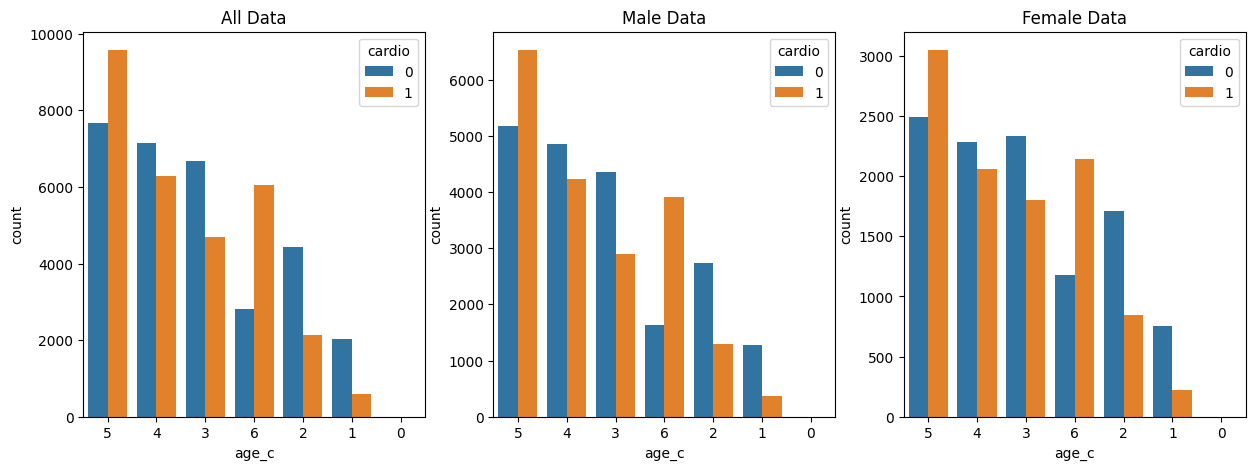

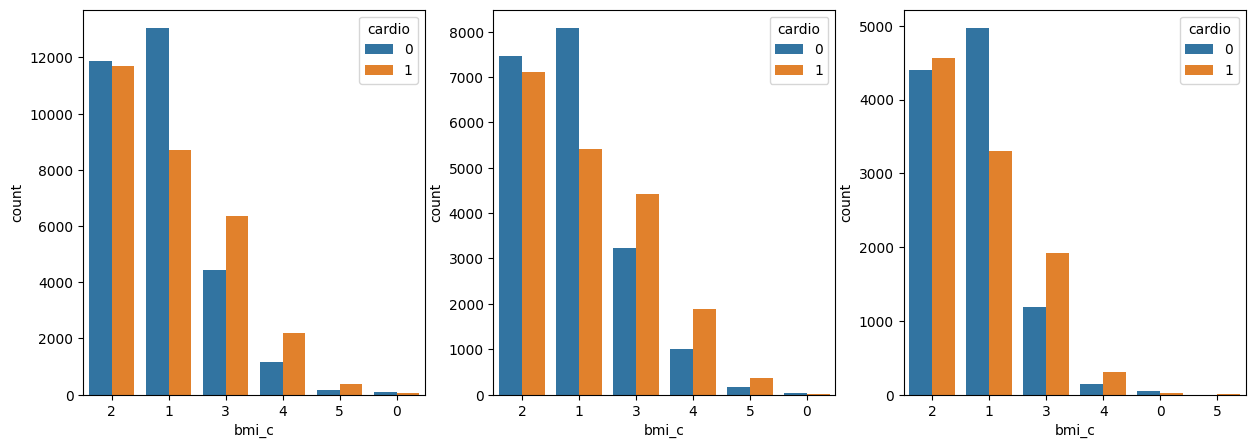

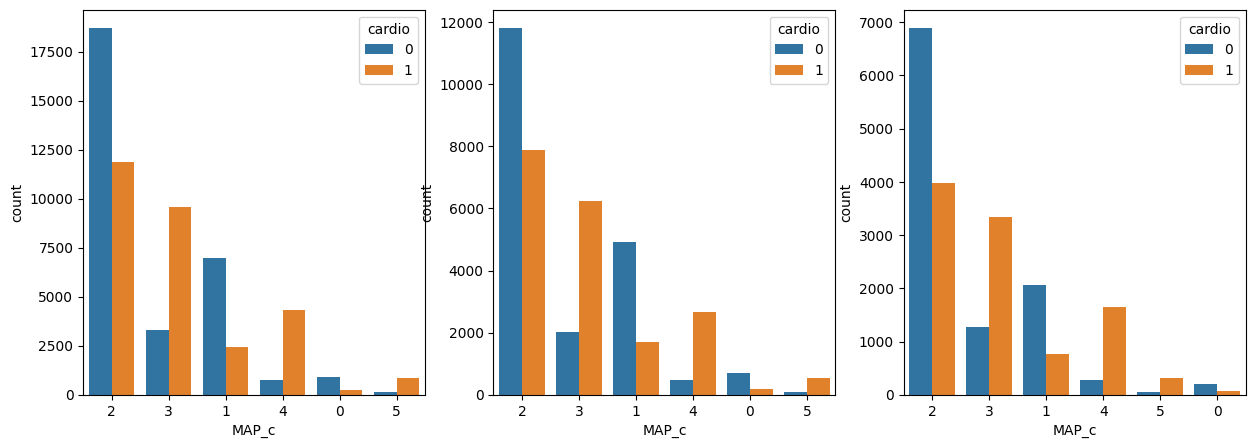

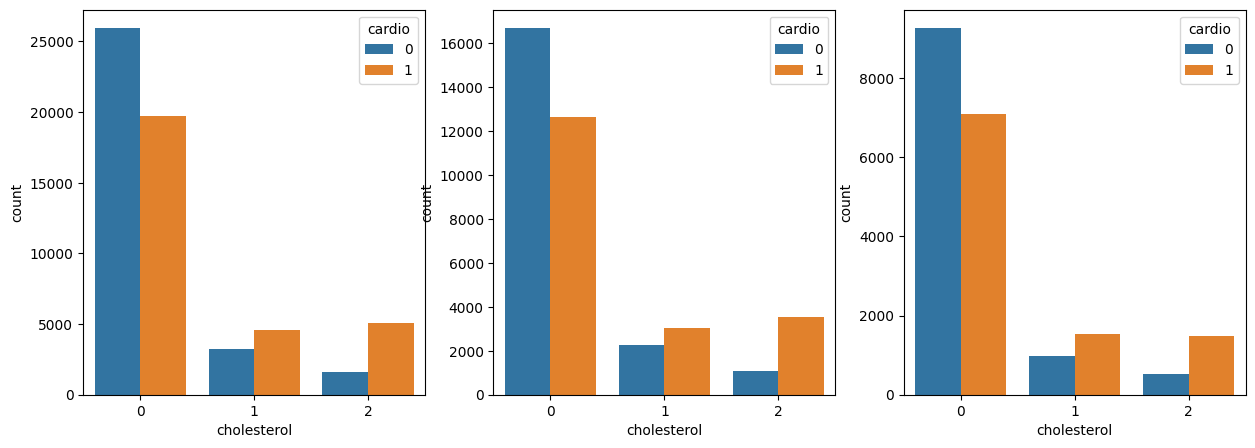

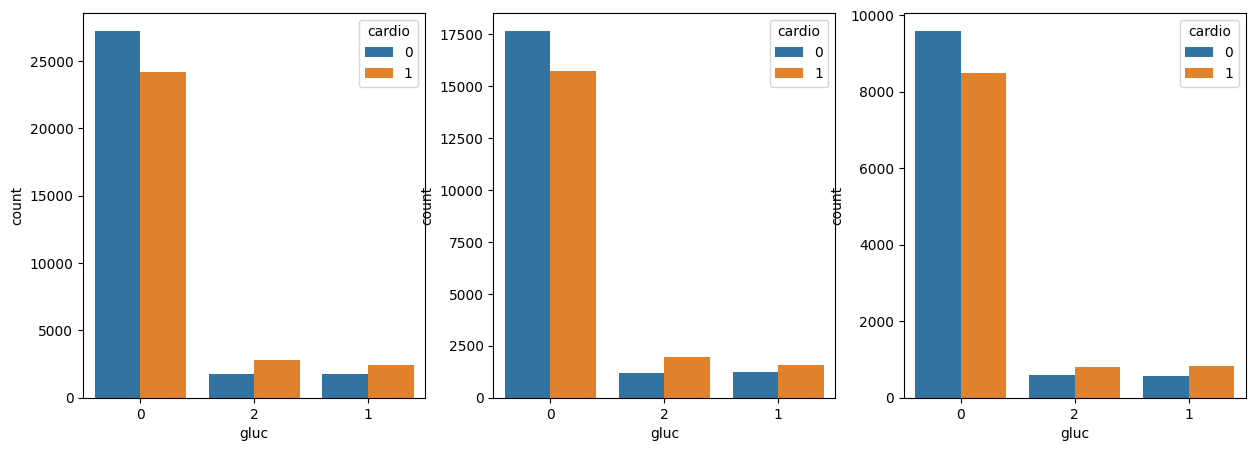

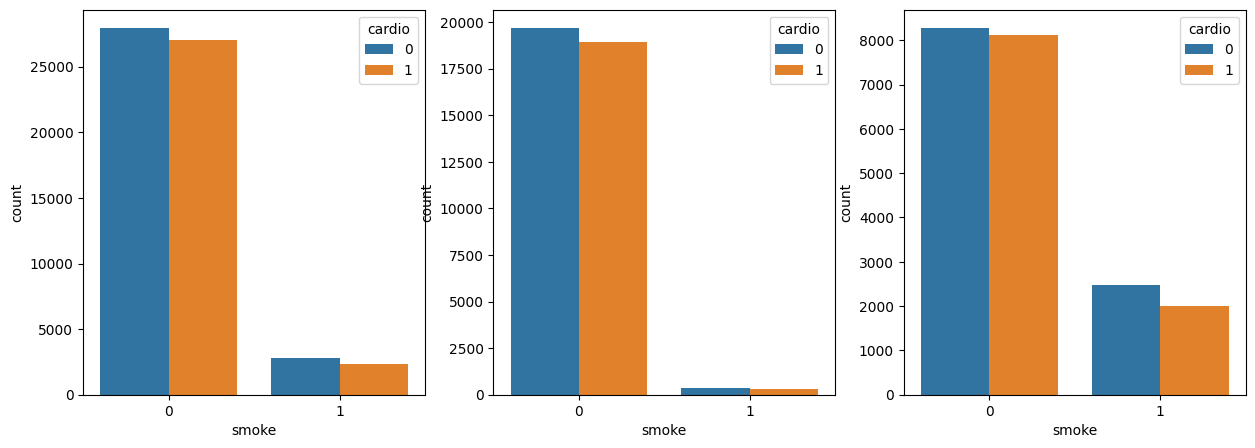

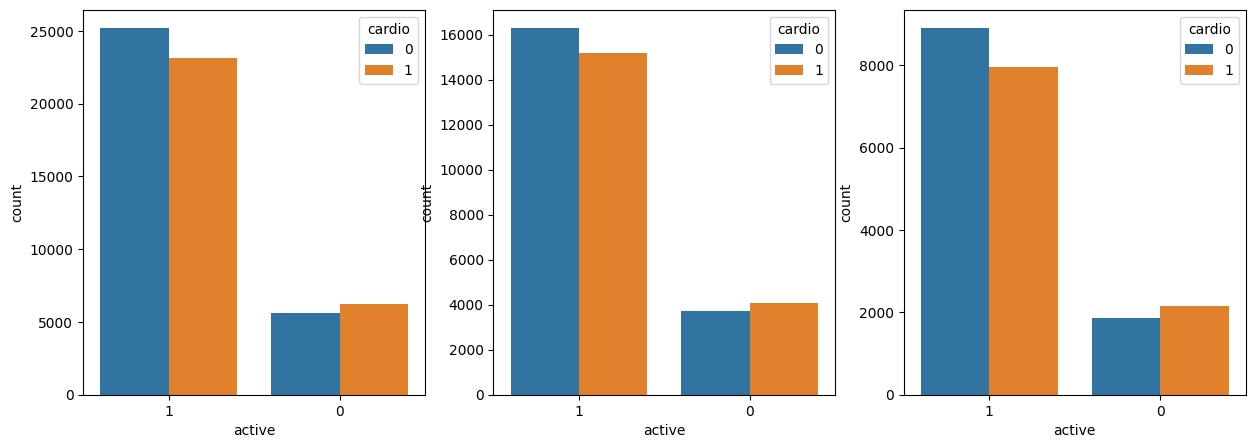

In [16]:
Obj.graphs()

In [17]:
Obj.kmodesfemale()

In [18]:
Obj.kmodesmale()

In [19]:
Obj.aggregation()

C:\Users\the_rainMaker\AppData\Local\Temp\ipykernel_5552\2288270765.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.maledata['Cluster'].replace({0:2,1:3},inplace=True)


In [20]:
Obj.traintestsplitML(patient_data)

Accuracy of decisiontree model on training dataset 87.51
Accuracy of decisiontree model on test dataset 86.29


Score of patient [0 1 1 1 0 1]
[[1.         0.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.         1.        ]
 [0.57142857 0.42857143]
 [0.         1.        ]]


Accuracy of randomforest model on training dataset 87.51
Accuracy of randomforest model on test dataset 86.59
Best Parameter :{} {'n_estimators': 300}


Score of patient [0 1 1 1 0 1]
[[0.93375356 0.06624644]
 [0.13740474 0.86259526]
 [0.12666667 0.87333333]
 [0.02543974 0.97456026]
 [0.57466982 0.42533018]
 [0.01333333 0.98666667]]


Accuracy of kneighborclassifier model on training dataset 84.41
Accuracy of kneighborclassifier model on test dataset 83.87
Accuracy of kneighborclassifier model on training dataset 85.33
Accuracy of kneighborclassifier model on test dataset 85.09
Accuracy of kneighborclassifier model on training dataset 85.14
Accuracy of kneighborclassifier model on test dataset 8

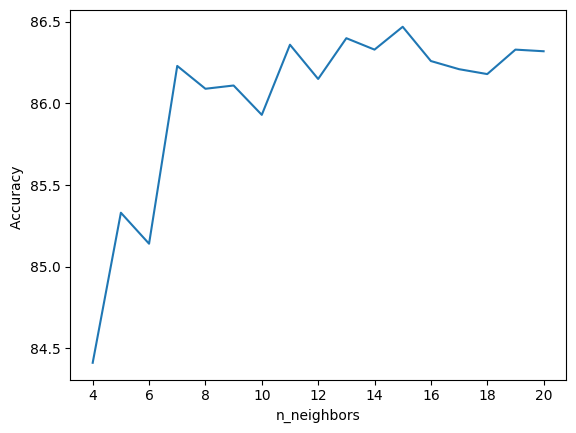

In [21]:
Obj.kneighborgraphfortraining()

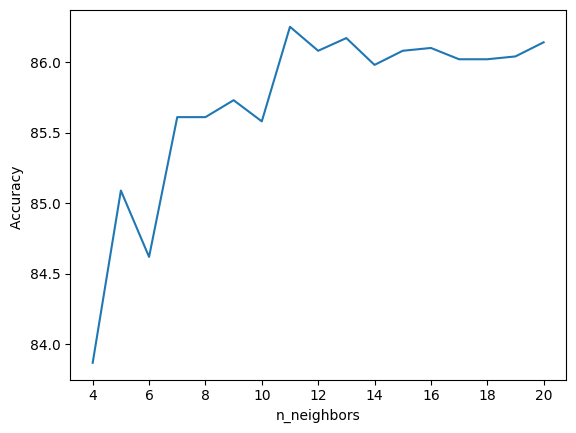

In [22]:
Obj.kneighborgraphfortesting()